# Lab 3 - Creating partitioned parquet files

In this lab, we will perform our first round of data preparation by writing the larger files (`XREF` and the yearly `parcel` files to the `parquet` format.  

In the process, we will discuss and investigate an important concept in managing lots of data: the principle of locality.  Big data problem as IO bound, meaning that almost all of the time/resources will be used managing the input/output of data.  The principle of locality holds that is often reused over a short period of time (temporal locality) and data that is stored in similar locations tend to be used at similar points in a program (spatial locality).  The `parquet` always us to partition a data set to leverage these properties.   *The correct partitioning can result in orders of magnitude speed up in processing time!*



## The Principle of Locality.

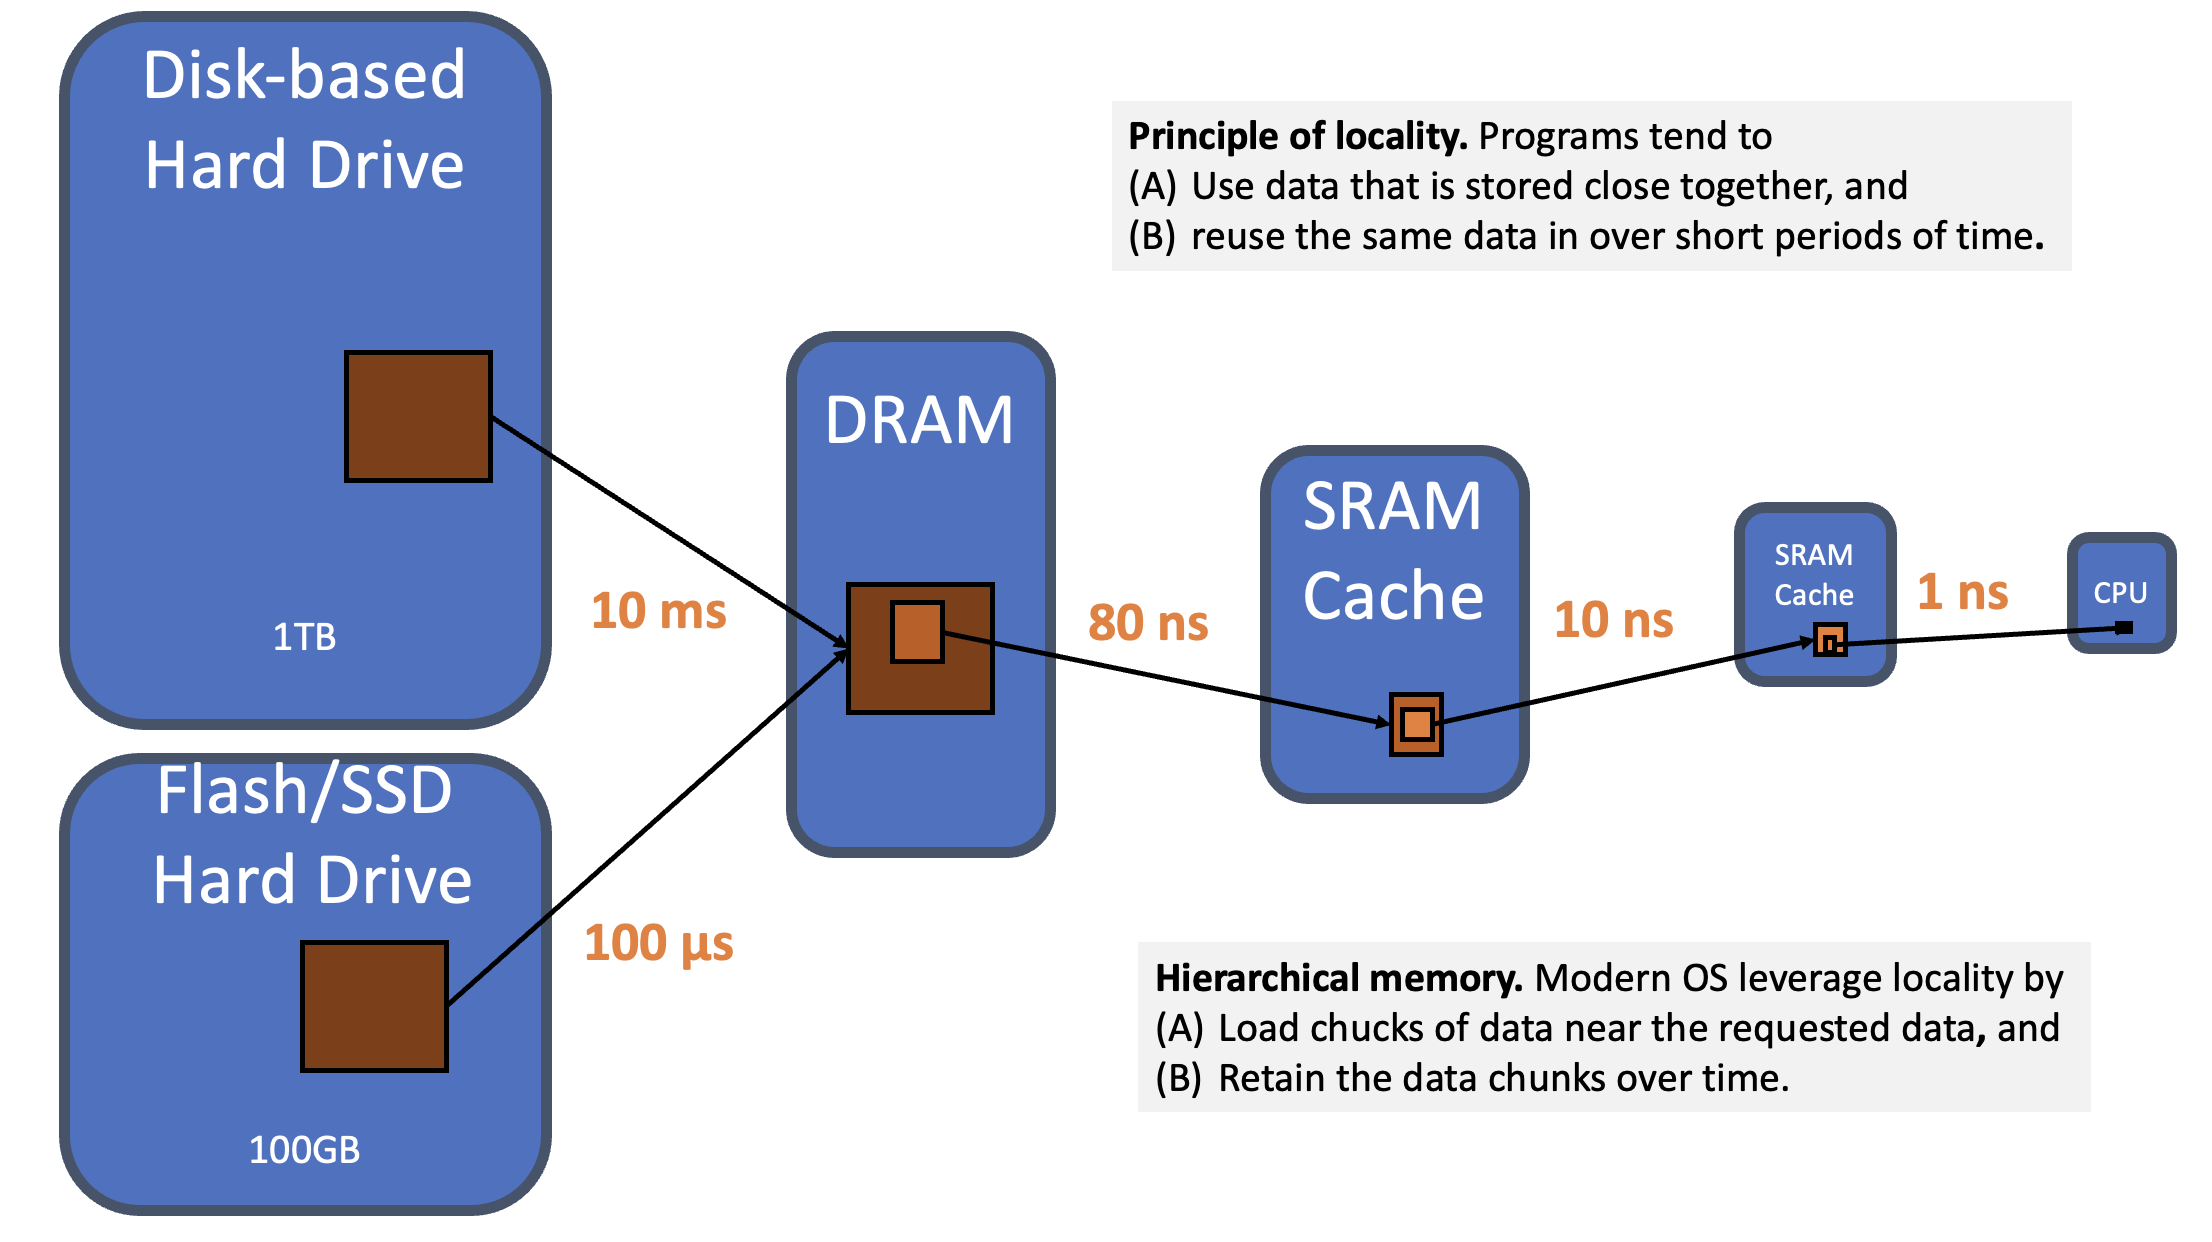

We can leverage the behavior of the operating system (OS)--in particular the loading of chucks of data in proximity and keeping that data in memory for a time--by partitioning our data so that similar data is stored together.

## We need to group the data by lake and distance to the lake

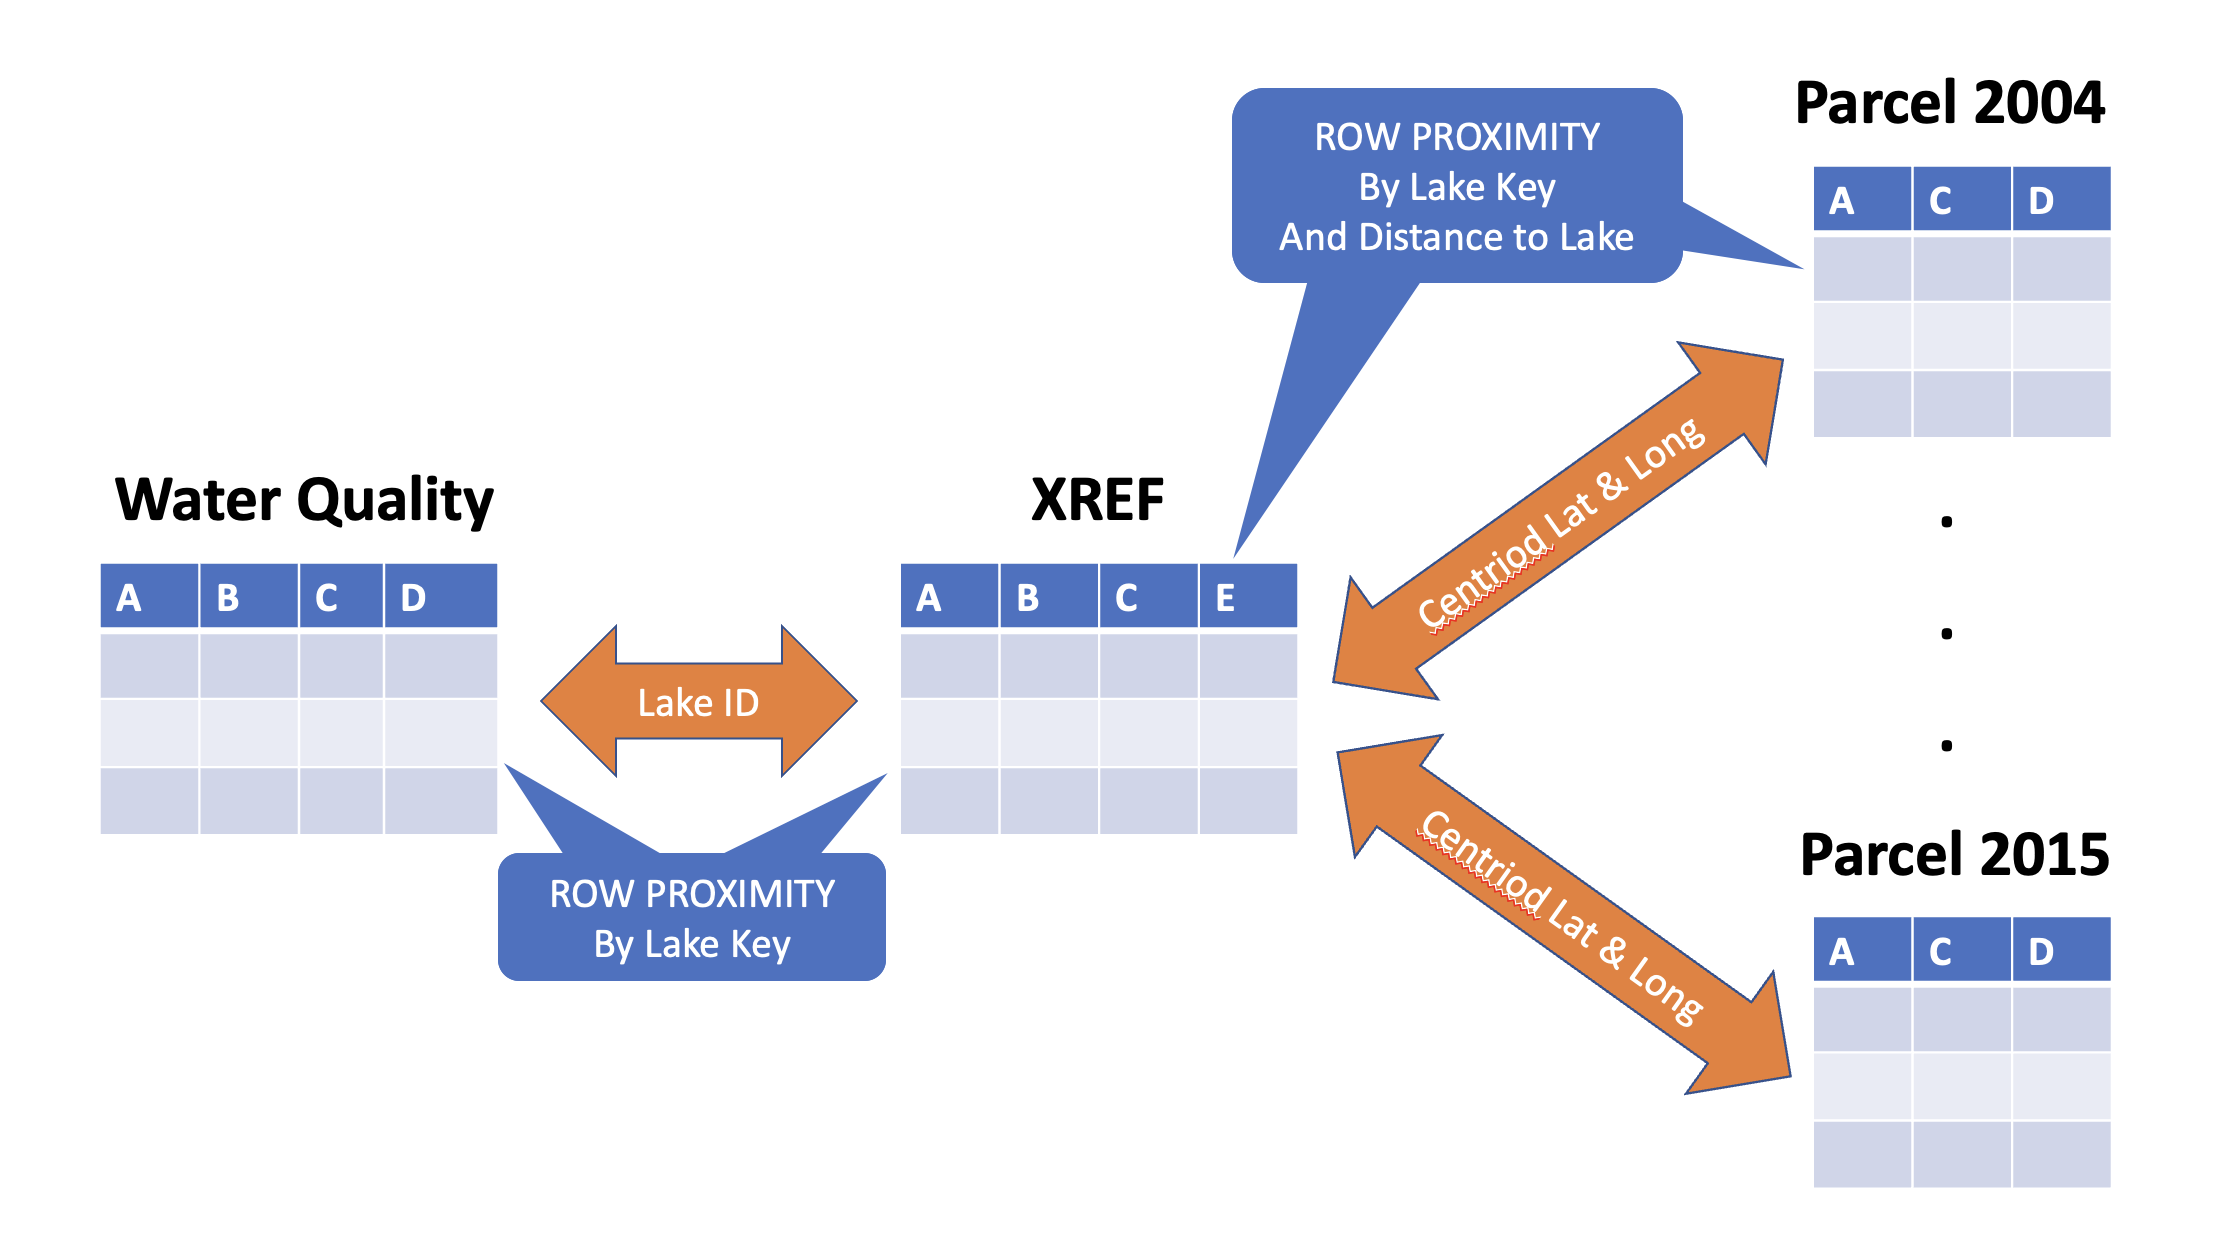

## Important notes on data size and platform selection

The primary challenge in big data processing is the size of the data.  In this lab, we will be working with the parcel files, which individually are small enough to fit into memory on a single machine, but become problematic when processed in bulk.  Furthermore, we will be aggregating and filtering the data during feature engineering, so storing the data in a columnar format will be beneficial for performance. 

Consequently, we will need to use `polars` support for reading and writing lazy data frames, such as `scan_csv`, `scan_parquet`, and `sink_parquet`, which will allow us to take full advatange of predicate and projection pushdown when processing the data.  This will help to minimize the amount of data that needs to be read and processed, which will improve performance.

## Problem 1 - Understanding the big picture and tables keys

**Tasks.**  

1. Explain why, in the case of parcel data, it is important to group the rows by lake id and distance to the lake.
2. Neither of these columns is present in the parcel data files.  How will we go about adding this information?

> <font color="orange"> Your thoughts here </font>

## Problem 2 - Writing the XREF to a partitioned parquet "file"

**Tasks.**  

1. Use `polars` to build a lazy query that performs the following tasks.
   - Scan the `XREF` data and select the relevant columns (Lake ID, centroid lat & long, distance to the lake).  Be sure to set `infer_schema=False` to keep the latitude and longitude columns as strings.<br>
   - Create a new categorical variable named with three categories based on distance to the lake: `within 500m`, `between 501-1600m`, and `over 1600m`.<br>
2. Test your query by collecting the first 10 or so rows using limit and collect.
3. Write the table as a partitioned parquet file (by Lake ID).

In [21]:
from glob import glob
import polars as pl
import polars.selectors as cs
import re
from functools import reduce      
from operator import mul 
 


In [22]:
# Place your code/thoughts in one or more code/markdown cells, respectively.\

glob ('data/*.txt')  

['data\\2002_metro_tax_parcels.txt',
 'data\\2003_metro_tax_parcels.txt',
 'data\\2004_metro_tax_parcels.txt',
 'data\\2005_metro_tax_parcels.txt',
 'data\\2006_metro_tax_parcels.txt',
 'data\\2007_metro_tax_parcels.txt',
 'data\\2008_metro_tax_parcels.txt',
 'data\\2009_metro_tax_parcels.txt',
 'data\\2010_metro_tax_parcels.txt',
 'data\\2011_metro_tax_parcels.txt',
 'data\\2012_metro_tax_parcels.txt',
 'data\\2013_metro_tax_parcels.txt',
 'data\\2014_metro_tax_parcels.txt',
 'data\\2015_metro_tax_parcels.txt',
 'data\\mces_lakes_1999_2014.txt',
 'data\\mces_lakes_1999_2014_v2.txt',
 'data\\Parcel_Lake_Monitoring_Site_Xref.txt']

In [23]:


(xref := 
    pl.scan_csv(
        'data/Parcel_Lake_Monitoring_Site_Xref.txt',
        separator='\t',
        infer_schema=False
    )
    .select([
        'Monit_MAP_CODE1',
        pl.col('Distance_Parcel_Lake_meters').cast(pl.Float64),
        'centroid_long',
        'centroid_lat'
    ])
    .with_columns(
        pl.when(pl.col('Distance_Parcel_Lake_meters') <= 500)
          .then(pl.lit('within_500m'))
          .when((pl.col('Distance_Parcel_Lake_meters') > 500) & 
                (pl.col('Distance_Parcel_Lake_meters') <= 1600))
          .then(pl.lit('between_501-1600m'))
          .otherwise(pl.lit('over_1600m'))
          .alias('distance_category')
    )
).limit(10).collect()



Monit_MAP_CODE1,Distance_Parcel_Lake_meters,centroid_long,centroid_lat,distance_category
str,f64,str,str,str
"""19007900-01""",2571.526792,"""-93.11451""","""44.94283""","""over_1600m"""
"""19007900-01""",2515.373802,"""-93.11539""","""44.94234""","""over_1600m"""
"""19007900-01""",2511.924959,"""-93.11556""","""44.94231""","""over_1600m"""
"""19007900-01""",2502.99164,"""-93.11572""","""44.94223""","""over_1600m"""
"""19007900-01""",2465.206234,"""-93.1158""","""44.94189""","""over_1600m"""
"""19007900-01""",2631.461256,"""-93.11218""","""44.94325""","""over_1600m"""
"""19007900-01""",3074.8658,"""-93.11036""","""44.94711""","""over_1600m"""
"""19007900-01""",3074.67095,"""-93.11048""","""44.94712""","""over_1600m"""
"""19007900-01""",3040.091456,"""-93.11042""","""44.9468""","""over_1600m"""


In [24]:
xref.columns

C:\Users\ym5765bo\AppData\Local\Temp\ipykernel_22596\565856385.py:1: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  xref.columns


['Monit_MAP_CODE1',
 'Distance_Parcel_Lake_meters',
 'centroid_long',
 'centroid_lat',
 'distance_category']

In [25]:
xref.sink_parquet(
    pl.PartitionByKey('data/xref_partitioned.parquet',
                   by= ['Monit_MAP_CODE1', 'distance_category']),
                   mkdir= True

)

### Part 3 - Inspecting the partitioned `parquet` file

**Tasks.** Inspect the resulting "file" (actually a folder) from the last set and answer the following questions.

1. What impact did the partitioning have on the way the data was saved?
2. How would this structure help `polars` apply predicate pushdown?
3. How would this structure provide help via the principle of locality.  
4. When working with a cluster of machines, operations such as `group_by` are WIDE operations, meaning they generally need to shuffle data between machines.  Such a suffle is *very* expensive.  In a future lab, we will be creating features for each labke by grouping and aggregating on the lakes and years.  How would applying a similar structure to the parcel data help in this case? **Hint.** Remember that the data will be distributed across multiple machines using the partitions, i.e., each machine will load all or some of the same partition(s).


> <font color="orange"> Your thoughts here </font>

### Part 4 - Filter parcels and joining lake id - one file

One of our programming principles is "do it to one before you do it to all".  Let's practice this by building a query using the `2004` file. Start by saving the path to the `2004` parcel file to the variable `q`.

**Tasks.** 

1. Write a query in `polars` that performs the following tasks.
   - Build a query to scan corresponding CSV, 
   - Selects common columns list the script file from the previous lab,
   - Joins on the necessary info from the `XREF` (lake ID, distance to the lake, distance category defined above, and centroid lat & long).
2. Test your query by collecting the first 10 or so rows using limit and collect.

Do this in a single `polars` dot chain.

**Important note.** When using a lazy query with a join, both tables must be lazy.  You can achieve this by using `pl.scan_csv` for the parcel data and `pl.read_parquet(...).lazy()` for the `XREF` data.

In [26]:
from cols_data import cols_to_keep
cols_to_keep

['ACRES_DEED',
 'ACRES_POLY',
 'AGPRE_ENRD',
 'AGPRE_EXPD',
 'AG_PRESERV',
 'BASEMENT',
 'BLDG_NUM',
 'BLOCK',
 'CITY',
 'CITY_USPS',
 'COOLING',
 'COUNTY_ID',
 'DWELL_TYPE',
 'EMV_BLDG',
 'EMV_LAND',
 'EMV_TOTAL',
 'FIN_SQ_FT',
 'GARAGE',
 'GARAGESQFT',
 'GREEN_ACRE',
 'HEATING',
 'HOMESTEAD',
 'HOME_STYLE',
 'LANDMARK',
 'LOT',
 'MULTI_USES',
 'NUM_UNITS',
 'OPEN_SPACE',
 'OWNER_MORE',
 'OWNER_NAME',
 'OWN_ADD_L1',
 'OWN_ADD_L2',
 'OWN_ADD_L3',
 'PARC_CODE',
 'PIN',
 'PLAT_NAME',
 'PREFIXTYPE',
 'PREFIX_DIR',
 'SALE_DATE',
 'SALE_VALUE',
 'SCHOOL_DST',
 'SPEC_ASSES',
 'STREETNAME',
 'STREETTYPE',
 'SUFFIX_DIR',
 'Shape_Area',
 'Shape_Leng',
 'TAX_ADD_L1',
 'TAX_ADD_L2',
 'TAX_ADD_L3',
 'TAX_CAPAC',
 'TAX_EXEMPT',
 'TAX_NAME',
 'TOTAL_TAX',
 'UNIT_INFO',
 'USE1_DESC',
 'USE2_DESC',
 'USE3_DESC',
 'USE4_DESC',
 'WSHD_DIST',
 'XUSE1_DESC',
 'XUSE2_DESC',
 'XUSE3_DESC',
 'XUSE4_DESC',
 'YEAR_BUILT',
 'Year',
 'ZIP',
 'ZIP4',
 'centroid_lat',
 'centroid_long']

In [27]:
# Your polars query here

(parcel_2004:= 
 pl.scan_csv('data/2004_metro_tax_parcels.txt',
                           separator= '|',
                           infer_schema= False)
                .select(cols_to_keep)
                .join(xref, 
                      left_on= ['centroid_lat', 'centroid_long'],
                      right_on= ['centroid_lat', 'centroid_long'],
                      how='inner')
                ).limit(10).collect()


ACRES_DEED,ACRES_POLY,AGPRE_ENRD,AGPRE_EXPD,AG_PRESERV,BASEMENT,BLDG_NUM,BLOCK,CITY,CITY_USPS,COOLING,COUNTY_ID,DWELL_TYPE,EMV_BLDG,EMV_LAND,EMV_TOTAL,FIN_SQ_FT,GARAGE,GARAGESQFT,GREEN_ACRE,HEATING,HOMESTEAD,HOME_STYLE,LANDMARK,LOT,MULTI_USES,NUM_UNITS,OPEN_SPACE,OWNER_MORE,OWNER_NAME,OWN_ADD_L1,OWN_ADD_L2,OWN_ADD_L3,PARC_CODE,PIN,PLAT_NAME,PREFIXTYPE,PREFIX_DIR,SALE_DATE,SALE_VALUE,SCHOOL_DST,SPEC_ASSES,STREETNAME,STREETTYPE,SUFFIX_DIR,Shape_Area,Shape_Leng,TAX_ADD_L1,TAX_ADD_L2,TAX_ADD_L3,TAX_CAPAC,TAX_EXEMPT,TAX_NAME,TOTAL_TAX,UNIT_INFO,USE1_DESC,USE2_DESC,USE3_DESC,USE4_DESC,WSHD_DIST,XUSE1_DESC,XUSE2_DESC,XUSE3_DESC,XUSE4_DESC,YEAR_BUILT,Year,ZIP,ZIP4,centroid_lat,centroid_long,Monit_MAP_CODE1,Distance_Parcel_Lake_meters,distance_category
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str
"""0.0""","""0.21""",null,null,"""N""",null,"""117""","""002""","""WACONIA CITY""","""WACONIA""",null,"""019""",null,"""127900.0""","""41800.0""","""169700.0""","""1124.0""","""Y""",null,"""N""",null,"""Y""","""SPLIT ENTY""",null,"""003""","""N""",null,null,null,null,null,null,null,"""1.0""","""019-752600170""","""FOX RUN 1ST ADDITION""",null,null,"""2004-05-20""","""207000.0""","""0110""","""21.0""","""CARVER""","""SQ""",null,null,null,"""117 CARVER SQ""","""WACONIA, MN 55387-9686""",null,"""0.0""",null,"""JOHNSON,ROBERT C""","""1715.0""",null,"""RESIDENTIAL""",null,null,null,"""CARVER CREEK CWM""",null,null,null,null,"""1982.0""","""2004""","""55387""","""9686""","""44.83933""","""-93.78435""","""10008400-01""",1561.777167,"""between_501-1600m"""
"""0.0""","""0.27""",null,null,"""N""",null,"""853""","""002""","""CARVER CITY""","""CARVER""",null,"""019""",null,"""194800.0""","""44600.0""","""239400.0""","""1324.0""","""Y""",null,"""N""",null,"""Y""","""COLONIAL""",null,"""002""","""N""",null,null,null,null,null,null,null,"""1.0""","""019-200890130""","""CARVER CREEK 4TH ADDITION""",null,null,"""2002-06-21""","""223388.0""","""0112""","""21.0""","""GILFILLAN""","""AVE""",null,null,null,"""853 GILFILLAN AVE""","""CARVER, MN 55315-4513""",null,"""0.0""",null,"""SANDERS,MARC A & GLYNIS R""","""3567.0""",null,"""RESIDENTIAL""",null,null,null,"""CARVER CREEK CWM""",null,null,null,null,"""2002.0""","""2004""","""55315""","""4513""","""44.75703""","""-93.63912""","""10003100-01""",3970.523552,"""over_1600m"""
"""0.0""","""0.0""",null,null,null,null,"""310""","""030""","""CHAMPLIN""","""CHAMPLIN""",null,"""053""",null,"""103100.0""","""35000.0""","""138100.0""","""0.0""",null,null,"""N""",null,"""Y""",null,null,null,null,null,"""N""",null,"""W A PELTIER & C PELTIER""",null,null,null,"""0.0""","""053-2412022140037""","""COLBURNS ADDN TOWNSITE OF CHAM…",null,null,"""2003-10-01""","""171000.0""","""011""","""0.0""","""GOODRICH AVE N""",null,null,"""893.736207033""","""121.441182114""","""310 GOODRICH AVE""","""CHAMPLIN MN 55316""",null,"""1247.0""","""N""","""WENDY & CORRIE PELTIER""","""1348.0""",null,null,null,null,null,"""0""",null,null,null,null,"""1962.0""","""2004""","""55316""",null,"""45.1906""","""-93.402""","""02008400-01""",4681.771544,"""over_1600m"""
"""0.0""","""0.46""",null,null,"""N""",null,"""834""","""002""","""CARVER CITY""","""CARVER""",null,"""019""",null,"""287600.0""","""70600.0""","""358200.0""","""1400.0""","""Y""",null,"""N""",null,"""Y""","""COLONIAL""",null,"""003""","""N""",null,null,null,null,null,null,null,"""1.0""","""019-200800220""","""CARVER BLUFFS SIXTH ADDITION""",null,null,"""2001-09-30""","""360149.0""","""0112""","""21.0""","""RAMSEY""","""AVE""",null,null,null,"""834 RAMSEY AVE""","""CARVER, MN 55315-4515""",null,"""0.0""",null,"""KNUTSEN,JOSEPH K & JENNIFER A""","""5583.0""",null,"""RESIDENTIAL""",null,null,null,"""CARVER CREEK CWM""",null,null,null,null,"""2002.0""","""

### Part 5 - Filter parcels and joining lake id - All files

Next, we will partition and write each of the 2004-2015 parcel files to a `parquet` "file".  To do this, complete each of the following tasks.

**Tasks.**

2. We need to adapt the query from the previous step to work for all the years, which can be accomplished by placing that query in a comprehension.  The query should perform the following tasks for each year from 2004-2015.
   - Scan the corresponding CSV (again, `infer_schema=False` to keep lat & long as strings), <br>
   - Select the common columns (import from `parcel.py`),<br>
   - Join on the necessary info from the `XREF` (lake ID, distance to the lake, distance category defined above, and centroid lat & long).<br>
   - Compute the distance to lake using the great circle distance, then construct the lake distance categorical variable as defined above.<br>
   <br>
   Do this in a single `polars` dot chain.<br>
3. Use a comprehension to create a list of lazy data frames for each year from 2004-2015 that contain the joined parcel data.  The expression should use the query from the previous step.  First, test your query on a limited number of rows (e.g., 1000) to ensure it works correctly.
4. Now we want to sink all of the parcel data to a single partitioned parquet "file".  You will need to 
    
**Important note.** When writing the parcel files separately, each parcel files took 10+ minutes on my laptop, so writing the combined file will take a while.  Pick a convenient time and be sure to plug in your laptop!

In [28]:
# Place your code/thoughts in one or more code/markdown cells, respectively.

(parcel_paths := sorted( [
    path for path in glob('data/*parcel*.txt')
    if any(str(year) in path for year in range(2004, 2016))
]))

['data\\2004_metro_tax_parcels.txt',
 'data\\2005_metro_tax_parcels.txt',
 'data\\2006_metro_tax_parcels.txt',
 'data\\2007_metro_tax_parcels.txt',
 'data\\2008_metro_tax_parcels.txt',
 'data\\2009_metro_tax_parcels.txt',
 'data\\2010_metro_tax_parcels.txt',
 'data\\2011_metro_tax_parcels.txt',
 'data\\2012_metro_tax_parcels.txt',
 'data\\2013_metro_tax_parcels.txt',
 'data\\2014_metro_tax_parcels.txt',
 'data\\2015_metro_tax_parcels.txt']

In [29]:
from cols_data import cols_to_keep
(parcel_lazy_queries := [
    pl.scan_csv(path, separator= '|',
                infer_schema =False)
                .select(cols_to_keep)
                .join(
                    xref,
                    left_on= ['centroid_lat', 'centroid_long'],
                      right_on= ['centroid_lat', 'centroid_long'],
                      how='inner'
                )
              for path in parcel_paths])

In [1]:
[q.limit(2).collect() for q in parcel_lazy_queries]

NameError: name 'parcel_lazy_queries' is not defined

In [ ]:
from column import getyear
from column import year_pattern
for q in parcel_lazy_queries:
     q.sink_parquet(pl.PartitionByKey(f'./data/parcel_combined.parquet',
       by= ["Year","Monit_MAP_CODE1", "distance_category"]),
       mkdir=True
     )


In [35]:
from humanize import naturalsize
from pathlib import Path

folder_size= lambda folder: sum(p.stat().st_size for p in Path (folder).rglob('*'))
naturalsize(folder_size('./data/parcel_combined.parquet'))

'1.9 GB'

In [ ]:
import pyarrow
pyarrow.__version__

'21.0.0'

In [ ]:
import polars
polars.__version__

'1.34.0'